In [1]:
import sys
sys.path.append("../")
from plotting import CandlePlot
import pandas as pd

In [2]:
df = pd.read_pickle("../data/GBP_JPY_H1.pkl")

In [3]:
df_an = df[['time', 'mid_o', 'mid_h', 'mid_l', 'mid_c']].copy()

In [4]:
df_an.tail()

,time,mid_o,mid_h,mid_l,mid_c
37219,2021-12-30 19:00:00+00:00,155.312,155.444,155.274,155.444
37220,2021-12-30 20:00:00+00:00,155.442,155.470,155.289,155.312
37221,2021-12-30 21:00:00+00:00,155.317,155.382,155.286,155.382
37222,2021-12-30 22:00:00+00:00,155.353,155.381,155.282,155.329
37223,2021-12-30 23:00:00+00:00,155.336,155.360,155.284,155.310


In [10]:
direction = df_an.mid_c - df_an.mid_o
body_size = abs(direction)
direction = [1 if x >= 0 else -1 for x in direction]
full_range = df_an.mid_h - df_an.mid_l
body_perc = (body_size / full_range) * 100
body_lower = df_an[['mid_c','mid_o']].min(axis=1)
body_upper = df_an[['mid_c','mid_o']].max(axis=1)
body_bottom_perc = ((body_lower - df_an.mid_l) / full_range) * 100
body_top_perc = 100 - (((df_an.mid_h - body_upper) / full_range) * 100)

In [11]:
df_an['body_lower'] = body_lower
df_an['body_upper'] = body_upper
df_an['body_bottom_perc'] = body_bottom_perc
df_an['body_top_perc'] = body_top_perc
df_an['body_perc'] = body_perc

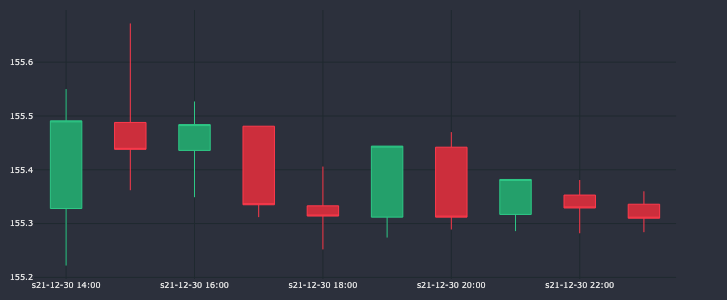

In [13]:
dfp = df_an.iloc[-10:]
cp = CandlePlot(dfp)
cp.show_plot(line_traces=[], height=300)

In [16]:
df_an.iloc[-6]

time                2021-12-30 18:00:00+00:00
mid_o                                 155.333
mid_h                                 155.406
mid_l                                 155.252
mid_c                                 155.314
body_lower                            155.314
body_upper                            155.333
body_bottom_perc                     40.25974
body_top_perc                       52.597403
body_perc                           12.337662
Name: 37218, dtype: object